# Clutter Suppression
### This is my attempt at clutter suppression...

In [1]:
# Imports
import numpy as np
from numpy import pi, log10
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
from scipy import signal
import netCDF4 as nc

### Attempting to replicate method shown in *Ground Clutter Mitigation for Weather Radars Using the Autocorrelation Spectral Density*

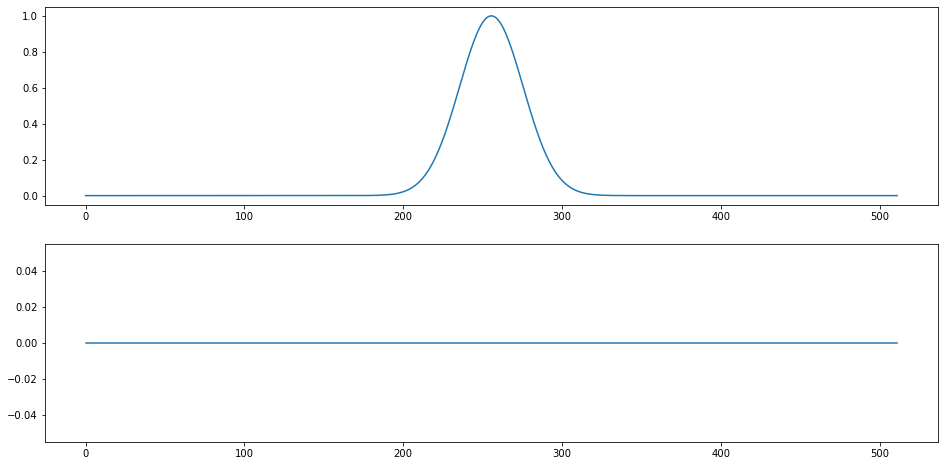

In [2]:
# Create gaussian clutter
M = 512
clutter = signal.windows.gaussian(M, 20)
clutter_phase = np.angle(clutter)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(8)
fig.set_figwidth(16)

ax1.plot(clutter)
ax2.plot(clutter_phase)

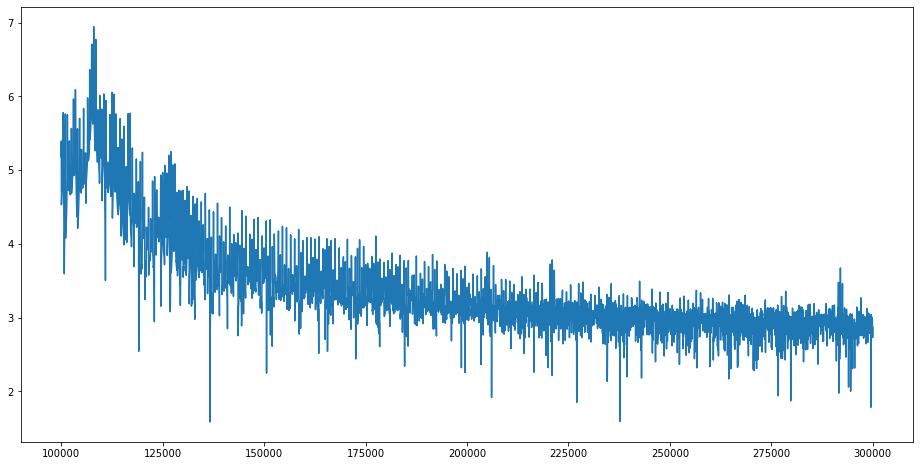

In [3]:
# Try with real data
ds = nc.Dataset('Data/Track_Test_Data_No_TDD.nc')
x_n = ds.variables['i'][0][:] + 1j * ds.variables['q'][0][:]
N = x_n.size

sample_rate = 600e3
ifreq = 100e3

X_k = fft(x_n)
# X_k /= np.max(X_k)
freq = fftshift(np.linspace(-sample_rate / 2, sample_rate / 2, N))

X_k = X_k[np.where(freq >= ifreq)]
freq = freq[np.where(freq >= ifreq)]

fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16)

ax1.plot(freq, log10(abs(X_k)))

## Lag-1 auto-correlation spectral density (ASD) function 
$ \begin {align}
    S_1[k] &= F_{0}^{*}[k]F_1[k] , &0 \le k \le M - 1 \\
    F_{l}^{*} &- \text{ Windowed complex conjugate of the lag }l\text{ DFT} \\
\end {align} $

/home/marchall/miniconda3/envs/phaser/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


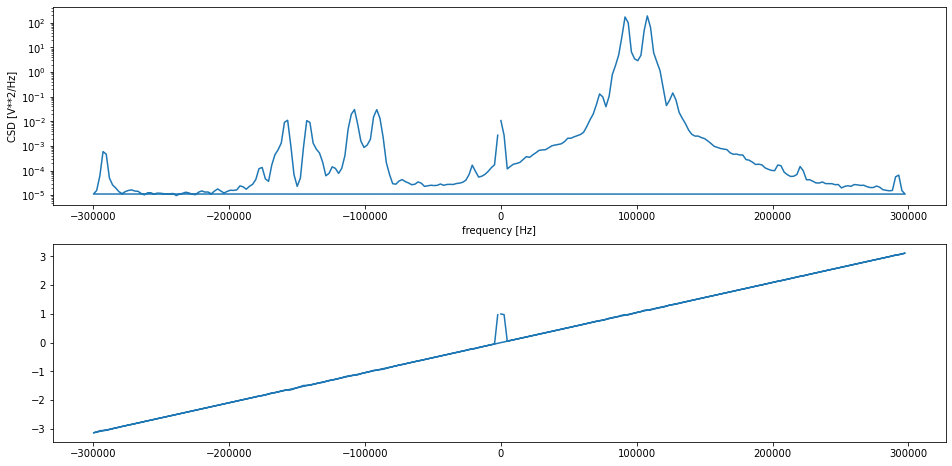

In [4]:
# Rectangular window
x_n_lag1 = x_n[1:]

f, Pxy = signal.csd(x_n, x_n_lag1, sample_rate)
phase = np.angle(Pxy)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.semilogy(f, abs(Pxy))
ax1.set_xlabel('frequency [Hz]')
ax1.set_ylabel('CSD [V**2/Hz]')
ax2.plot(f, phase)
fig.set_figheight(8)
fig.set_figwidth(16)

Frequency resolution (from BW): 1000.00Hz
Frequency resolution (from Ts and N): 36.62Hz
Range resolution: 0.30m
Zero-padding amount: 2
(196, 28)
(196,)


/tmp/ipykernel_5203/3469817528.py:32: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(freq_bin, log10(abs(X_k_bin)))


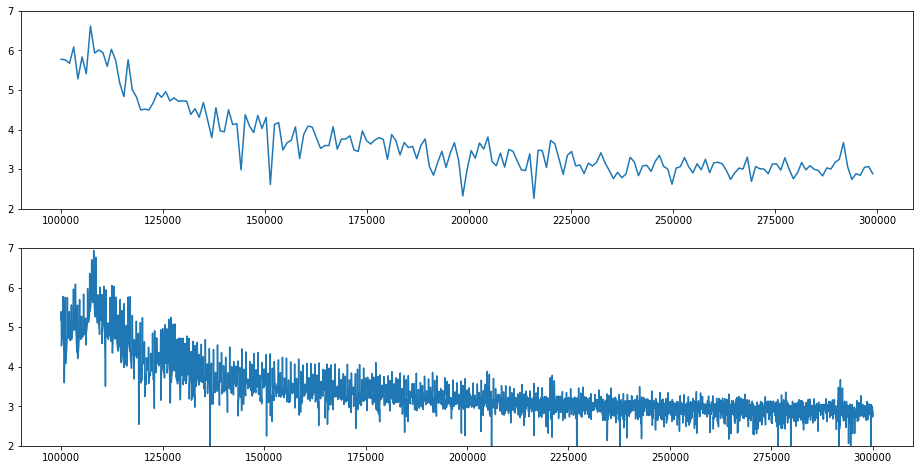

In [11]:
bw = 500e6
t_ramp = 1e-3
slope = bw / t_ramp
c = 3e8
r_res = c / (2 * bw)
f_res = 2 * r_res * slope / c

f_diff = sample_rate / N
# Range bin size
n = int(np.ceil(f_res / f_diff))

print('Frequency resolution (from BW): %0.2fHz\nFrequency resolution (from Ts and N): %0.2fHz\nRange resolution: %0.2fm' % (f_res, f_diff, r_res))

pad_amount = n - (X_k.size % n)
X_k_bin = np.pad(X_k, (0, pad_amount), 'constant')

print('Zero-padding amount: %i' % (X_k.size % n))

X_k_bin = X_k_bin.reshape(-1, n)
print(X_k_bin.shape)
X_k_bin = np.max(X_k_bin, axis=1)
print(X_k_bin.shape)

freq_bin = np.linspace(100e3, 300e3, X_k_bin.size)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(8)
fig.set_figwidth(16)
ax1.set_ylim(2, 7)
ax2.set_ylim(2, 7)

ax1.plot(freq_bin, log10(abs(X_k_bin)))
ax2.plot(freq, log10(abs(X_k)))


182.79990730702593


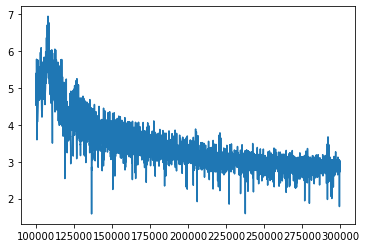

In [39]:
freq = fftshift(np.linspace(-sample_rate / 2, sample_rate / 2, N))

x_n_norm = x_n - np.mean(x_n)
X_k_norm = fft(x_n_norm)
X_k_norm = X_k_norm[np.where(freq >= ifreq)]

freq = freq[np.where(freq >= ifreq)]
plt.plot(freq, log10(abs(X_k_norm)))

p_n = np.std(x_n_norm)**2 / 2
print(p_n / 2**12)